In [7]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
import pickle
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline
from gensim.models import Word2Vec
from sklearn.preprocessing import normalize
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph 
import multiprocessing
import matplotlib.pyplot as plt
from joblib import Parallel,delayed
from tqdm import tqdm

In [8]:
metapaths = [
    ["author", "paper", "author"],
    ["author", "paper", "term", "paper", "author"],
    ["author", "paper", "conf", "paper", "author"],
]


model_save_path = 'model_save_dir'
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)
model_save_path = os.path.join(model_save_path,'DBLP')
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)
    
    
model_use_data_DIR = 'model_use_data'
if not os.path.exists(model_use_data_DIR):
    os.mkdir(model_use_data_DIR)
model_use_data_DIR = os.path.join(model_use_data_DIR,'DBLP')
if not os.path.exists(model_use_data_DIR):
    os.mkdir(model_use_data_DIR)
    
walk_length = 64
num_walks_per_node = 40
emb_dim = 256
emb_fpath = os.path.join(model_save_path, 'mp2v_{}_{}_{}.npy'.format(emb_dim,num_walks_per_node,walk_length))



In [9]:
src_dir = './dblp/processed_data/'

nodes_author_df = pd.read_csv(
    os.path.join(
        src_dir,
        'nodes_author.csv'),
    index_col = 0
)
nodes_paper_df = pd.read_csv(
    os.path.join(
        src_dir,
        'nodes_paper.csv'),
    index_col = 0
)
nodes_term_df = pd.read_csv(
    os.path.join(
        src_dir,
        'nodes_term.csv'),
    index_col = 0
)
nodes_conf_df = pd.read_csv(
    os.path.join(
        src_dir,
        'nodes_conf.csv'),
    index_col = 0
)


fpath_list = ['PT_edges.csv','PC_edges.csv','PA_edges.csv']
df_edges = None
for fpath in fpath_list:
    _df = pd.read_csv( os.path.join(src_dir,fpath), index_col = None )
    if df_edges is None : df_edges = _df
    else:
        df_edges = df_edges.append(_df,ignore_index= True)


In [10]:

graph_obj = StellarGraph({
    "author": nodes_author_df, 
    "paper":nodes_paper_df,
    "term": nodes_term_df,
    "conf": nodes_conf_df
},
    df_edges
)

In [30]:
print(len(graph_obj.edges()))
print(np.mean(list(graph_obj.node_degrees().values())))

301369
16.076014189315337


In [11]:
# walks = rw.run(
#     nodes=list(g.nodes()),  # root nodes
#     length=walk_length,  # maximum length of a random walk
#     n=1,  # number of random walks per root node
#     metapaths=metapaths,  # the metapaths
# )

In [12]:
def generate_random_walks(graph_obj , num_walks_per_node, walk_length, metapaths):
    random_walk_object = UniformRandomMetaPathWalk(graph_obj)
    cpu_count = multiprocessing.cpu_count()
    list_nodes = list(graph_obj.nodes())
    num_chunks = cpu_count
    chunk_len = (len(list_nodes)//num_chunks)
    chunks = [list_nodes[i*chunk_len: (i+1)*chunk_len ] for i in range(0, num_chunks+1)]
    
    res =  Parallel(n_jobs=cpu_count)(
        delayed(aux_gen_walks)(
            node_chunk, walk_length, random_walk_object, metapaths, num_walks_per_node 
        ) 
        for node_chunk in chunks
    )
    
    all_walks = []
    for r in res:
        all_walks.extend(r)
    return all_walks

def aux_gen_walks(
    node_chunk, 
    walk_length, 
    random_walk_object,
    metapaths = None,
    num_walks = 1
):
    walks = random_walk_object.run(
        nodes=node_chunk,
        length=walk_length,
        n=num_walks,
        metapaths=metapaths
    )
    return walks

In [13]:

walks_save_file = "mp2v_random_walks_{}_{}.npy".format(walk_length, num_walks_per_node)
walks_save_file = os.path.join(model_use_data_DIR, walks_save_file)
try:
    walks_np_arr = np.load( walks_save_file )
    walks = [ list(_) for _ in walks_np_arr]
except:
    walks = generate_random_walks(graph_obj, num_walks_per_node, walk_length, metapaths)
    walks_np_arr = np.array(walks)
    np.save( walks_save_file, walks_np_arr)

print("Number of random walks: {}".format(len(walks)))


Number of random walks: 296400


In [14]:
str_walks = [[str(n) for n in walk] for walk in walks]

In [15]:
if not os.path.exists(emb_fpath):
    
    word2vec_params = {
       'sg': 0, 
       "size": emb_dim,
       "alpha": 0.5,
       "min_alpha": 0.001,
       'window':5,
       'min_count': 0,
       "workers": multiprocessing.cpu_count(),
       "negative": 1,
       "hs": 0,  # 0: negative sampling, 1:hierarchical  softmax
       'compute_loss': True,
       'iter': 10,
       'cbow_mean':1,
    }

    iters = 60
    mp2v_model = Word2Vec(**word2vec_params)
    mp2v_model.build_vocab(str_walks)
    losses = []
    learning_rate = 0.5
    step_size = (0.5 - 0.001) / iters
    
    
    for i in tqdm(range(iters)):
        trained_word_count, raw_word_count = mp2v_model.train(
            str_walks, 
            compute_loss=True,
            start_alpha=learning_rate,
            end_alpha=learning_rate,
            total_examples=mp2v_model.corpus_count,
            epochs=1
        )
        loss = mp2v_model.get_latest_training_loss()
        losses.append(loss)
        print('>> ', i, ' Loss:: ', loss, learning_rate)
        learning_rate -= step_size
    
    # ======== Save node weights ============ #
    node_embeddings = []
    for i in range(len(graph_obj.nodes())):
        vec = mp2v_model.wv[str(i)]
        node_embeddings.append(vec)

    node_embeddings = np.array(node_embeddings)
    np.save(emb_fpath, node_embeddings )
else:
    node_embeddings =  np.load(emb_fpath)
    

  2%|▏         | 1/60 [00:08<08:34,  8.72s/it]

>>  0  Loss::  128909.1953125 0.5


  3%|▎         | 2/60 [00:17<08:25,  8.71s/it]

>>  1  Loss::  11394.53125 0.49168333333333336


  5%|▌         | 3/60 [00:26<08:14,  8.68s/it]

>>  2  Loss::  6652.9892578125 0.4833666666666667


  7%|▋         | 4/60 [00:34<08:05,  8.66s/it]

>>  3  Loss::  5005.93701171875 0.4750500000000001


  8%|▊         | 5/60 [00:43<07:56,  8.66s/it]

>>  4  Loss::  3903.59130859375 0.46673333333333344


 10%|█         | 6/60 [00:52<07:48,  8.67s/it]

>>  5  Loss::  2997.712158203125 0.4584166666666668


 12%|█▏        | 7/60 [01:00<07:39,  8.67s/it]

>>  6  Loss::  2675.649169921875 0.45010000000000017


 13%|█▎        | 8/60 [01:09<07:30,  8.66s/it]

>>  7  Loss::  2235.735595703125 0.4417833333333335


 15%|█▌        | 9/60 [01:18<07:21,  8.66s/it]

>>  8  Loss::  1957.077880859375 0.4334666666666669


 17%|█▋        | 10/60 [01:26<07:13,  8.67s/it]

>>  9  Loss::  2076.942138671875 0.42515000000000025


 18%|█▊        | 11/60 [01:35<07:04,  8.67s/it]

>>  10  Loss::  1556.505859375 0.4168333333333336


 20%|██        | 12/60 [01:44<06:56,  8.67s/it]

>>  11  Loss::  1659.4661865234375 0.40851666666666697


 22%|██▏       | 13/60 [01:52<06:47,  8.67s/it]

>>  12  Loss::  1468.7178955078125 0.40020000000000033


 23%|██▎       | 14/60 [02:01<06:39,  8.67s/it]

>>  13  Loss::  1476.2620849609375 0.3918833333333337


 25%|██▌       | 15/60 [02:10<06:30,  8.67s/it]

>>  14  Loss::  1332.80224609375 0.38356666666666706


 27%|██▋       | 16/60 [02:18<06:21,  8.66s/it]

>>  15  Loss::  1143.7080078125 0.3752500000000004


 28%|██▊       | 17/60 [02:27<06:12,  8.66s/it]

>>  16  Loss::  1315.444091796875 0.3669333333333338


 30%|███       | 18/60 [02:36<06:04,  8.67s/it]

>>  17  Loss::  1063.12060546875 0.35861666666666714


 32%|███▏      | 19/60 [02:44<05:55,  8.67s/it]

>>  18  Loss::  1099.2347412109375 0.3503000000000005


 33%|███▎      | 20/60 [02:53<05:47,  8.68s/it]

>>  19  Loss::  1159.6959228515625 0.34198333333333386


 35%|███▌      | 21/60 [03:02<05:38,  8.68s/it]

>>  20  Loss::  1114.4464111328125 0.3336666666666672


 37%|███▋      | 22/60 [03:10<05:29,  8.67s/it]

>>  21  Loss::  1102.7003173828125 0.3253500000000006


 38%|███▊      | 23/60 [03:19<05:20,  8.67s/it]

>>  22  Loss::  982.0811767578125 0.31703333333333394


 40%|████      | 24/60 [03:28<05:11,  8.66s/it]

>>  23  Loss::  910.0264282226562 0.3087166666666673


 42%|████▏     | 25/60 [03:36<05:03,  8.67s/it]

>>  24  Loss::  804.2100830078125 0.30040000000000067


 43%|████▎     | 26/60 [03:45<04:54,  8.67s/it]

>>  25  Loss::  777.9080200195312 0.292083333333334


 45%|████▌     | 27/60 [03:54<04:46,  8.68s/it]

>>  26  Loss::  897.8666381835938 0.2837666666666674


 47%|████▋     | 28/60 [04:03<04:41,  8.79s/it]

>>  27  Loss::  759.2384643554688 0.27545000000000075


 48%|████▊     | 29/60 [04:12<04:32,  8.80s/it]

>>  28  Loss::  931.9310913085938 0.2671333333333341


 50%|█████     | 30/60 [04:20<04:22,  8.76s/it]

>>  29  Loss::  860.747314453125 0.25881666666666747


 52%|█████▏    | 31/60 [04:29<04:13,  8.74s/it]

>>  30  Loss::  867.5943603515625 0.25050000000000083


 53%|█████▎    | 32/60 [04:38<04:04,  8.73s/it]

>>  31  Loss::  791.3754272460938 0.24218333333333417


 55%|█████▌    | 33/60 [04:46<03:55,  8.73s/it]

>>  32  Loss::  679.3552856445312 0.2338666666666675


 57%|█████▋    | 34/60 [04:55<03:46,  8.71s/it]

>>  33  Loss::  873.2122802734375 0.22555000000000083


 58%|█████▊    | 35/60 [05:04<03:37,  8.72s/it]

>>  34  Loss::  650.6174926757812 0.21723333333333417


 60%|██████    | 36/60 [05:12<03:28,  8.71s/it]

>>  35  Loss::  762.5008544921875 0.2089166666666675


 62%|██████▏   | 37/60 [05:21<03:19,  8.69s/it]

>>  36  Loss::  717.7901611328125 0.20060000000000083


 63%|██████▎   | 38/60 [05:30<03:10,  8.68s/it]

>>  37  Loss::  741.0516357421875 0.19228333333333417


 65%|██████▌   | 39/60 [05:38<03:02,  8.69s/it]

>>  38  Loss::  685.87255859375 0.1839666666666675


 67%|██████▋   | 40/60 [05:47<02:53,  8.69s/it]

>>  39  Loss::  714.6616821289062 0.17565000000000083


 68%|██████▊   | 41/60 [05:56<02:45,  8.69s/it]

>>  40  Loss::  651.721435546875 0.16733333333333417


 70%|███████   | 42/60 [06:04<02:36,  8.69s/it]

>>  41  Loss::  688.0272827148438 0.1590166666666675


 72%|███████▏  | 43/60 [06:13<02:27,  8.69s/it]

>>  42  Loss::  710.3096923828125 0.15070000000000083


 73%|███████▎  | 44/60 [06:22<02:19,  8.70s/it]

>>  43  Loss::  724.1976318359375 0.14238333333333417


 75%|███████▌  | 45/60 [06:31<02:10,  8.68s/it]

>>  44  Loss::  670.9089965820312 0.1340666666666675


 77%|███████▋  | 46/60 [06:39<02:01,  8.67s/it]

>>  45  Loss::  799.7042846679688 0.12575000000000083


 78%|███████▊  | 47/60 [06:48<01:52,  8.67s/it]

>>  46  Loss::  715.269287109375 0.11743333333333417


 80%|████████  | 48/60 [06:57<01:44,  8.67s/it]

>>  47  Loss::  722.02880859375 0.1091166666666675


 82%|████████▏ | 49/60 [07:05<01:35,  8.67s/it]

>>  48  Loss::  697.9761962890625 0.10080000000000083


 83%|████████▎ | 50/60 [07:14<01:26,  8.67s/it]

>>  49  Loss::  666.1499633789062 0.09248333333333417


 85%|████████▌ | 51/60 [07:23<01:18,  8.68s/it]

>>  50  Loss::  663.5596923828125 0.0841666666666675


 87%|████████▋ | 52/60 [07:31<01:09,  8.68s/it]

>>  51  Loss::  659.3944091796875 0.07585000000000083


 88%|████████▊ | 53/60 [07:40<01:00,  8.67s/it]

>>  52  Loss::  627.8551025390625 0.06753333333333417


 90%|█████████ | 54/60 [07:49<00:52,  8.68s/it]

>>  53  Loss::  684.50732421875 0.0592166666666675


 92%|█████████▏| 55/60 [07:57<00:43,  8.69s/it]

>>  54  Loss::  725.2025756835938 0.05090000000000083


 93%|█████████▎| 56/60 [08:06<00:34,  8.67s/it]

>>  55  Loss::  675.4561157226562 0.04258333333333417


 95%|█████████▌| 57/60 [08:15<00:26,  8.68s/it]

>>  56  Loss::  710.4968872070312 0.0342666666666675


 97%|█████████▋| 58/60 [08:23<00:17,  8.67s/it]

>>  57  Loss::  693.5601806640625 0.025950000000000834


 98%|█████████▊| 59/60 [08:32<00:08,  8.66s/it]

>>  58  Loss::  614.7020263671875 0.017633333333334167


100%|██████████| 60/60 [08:41<00:00,  8.69s/it]

>>  59  Loss::  587.177490234375 0.0093166666666675


In [16]:
len(graph_obj.nodes())

37493

In [17]:
entity_id_mapping = pd.read_csv(src_dir + 'entity_id_mapping.csv')

In [21]:
# normalization, embedding to 512, different metapathes

In [18]:
node_embeddings_normalized = normalize(node_embeddings, axis=1, norm='l1')

In [19]:
embedding_dict = {'user': {}, 'skill': {}}
for i, row in entity_id_mapping.iterrows():
    if row['domain'] == 'author':
        embedding_dict['user'].update({row['entity_id']: node_embeddings_normalized[row['serial_id']]})  
    elif row['domain'] == 'term':
        embedding_dict['skill'].update({row['entity_id']: node_embeddings_normalized[row['serial_id']]}) 
pickle.dump(embedding_dict, open(model_save_path + '/embedding_dict.pkl', 'wb'))

In [20]:
embedding_dict.get('user')[5]

array([-3.05167632e-03,  4.73983074e-03,  9.94383474e-04, -2.15707556e-03,
       -6.05775462e-03,  6.03964413e-03,  6.72149705e-03, -3.27874697e-03,
        1.68538466e-03,  1.16507767e-03, -1.37406343e-03, -4.85481881e-03,
       -7.32995759e-05,  3.48904775e-03, -4.40416997e-03, -2.82393838e-03,
       -1.13354623e-03,  9.17123817e-03, -1.20071750e-02,  4.54859668e-03,
        4.31495393e-03, -5.36915846e-03,  1.07770795e-02,  1.00268715e-03,
       -8.63517867e-04, -7.60433683e-03, -8.36704276e-04, -3.32803396e-03,
        4.51303460e-03, -3.12098558e-03, -8.83104000e-03, -9.06815476e-05,
       -1.54104666e-03,  1.30715221e-02,  2.97615887e-03, -1.12869975e-03,
        3.60807707e-03,  6.34352025e-03, -3.28637683e-03,  1.40872679e-03,
       -4.20864299e-03,  4.18199878e-03,  5.13782678e-03,  6.40052557e-03,
        4.78941668e-03, -2.94147385e-03,  4.21926175e-04,  5.68236085e-03,
        2.10319809e-03, -2.90189940e-03,  4.31741681e-03,  1.47889624e-03,
       -1.90419366e-03,  

In [22]:
tsne = TSNE(
    n_components=2, 
    perplexity = 30.0, 
    early_exaggeration=25.0, 
    learning_rate=250
)
node_embeddings_2d = tsne.fit_transform(node_embeddings, )

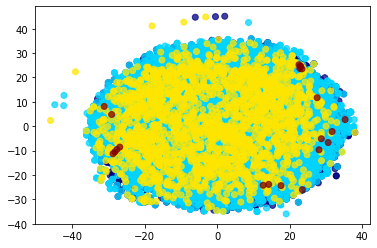

In [23]:
l = 0
node_ids = []
labels = []
df_list = [ nodes_author_df, nodes_paper_df, nodes_term_df, nodes_conf_df]

for _df in df_list:
    _df = _df.reset_index()
    col = list(_df.columns)[0]
    k = list(_df[col])
    node_ids.extend(k)
    labels.extend([l]*len(_df))
    l+=1


plt.figure(figsize=(10, 8))
%matplotlib inline 
node_colours = labels
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=0.75,
)

plt.show()

In [80]:
tsne = TSNE(
    n_components=3, 
    perplexity = 30.0, 
    early_exaggeration=25.0, 
    learning_rate=250
)
node_embeddings_3d = tsne.fit_transform(node_embeddings, )

In [81]:
l = 0
node_ids = []
labels = []
df_list = [ nodes_author_df, nodes_paper_df, nodes_term_df, nodes_conf_df]

for _df in df_list:
    _df = _df.reset_index()
    col = list(_df.columns)[0]
    k = list(_df[col])
    node_ids.extend(k)
    labels.extend([l]*len(_df))
    l+=1


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

node_colours = labels
ax.scatter(
    node_embeddings_3d[:, 0],
    node_embeddings_3d[:, 1],
    node_embeddings_3d[:, 2],
    c=node_colours,
    cmap="jet",
    alpha=0.75,
)